<a href="https://colab.research.google.com/github/samsung-chow/324-Project/blob/main/V1_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload cleaned_data.CSV (in github repo)
from google.colab import files
uploaded = files.upload()

Saving cleaned_data.CSV to cleaned_data (1).CSV


Accuracy: 0.8188932364449413
Confusion Matrix:
 [[799 158]
 [166 666]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       957
           1       0.81      0.80      0.80       832

    accuracy                           0.82      1789
   macro avg       0.82      0.82      0.82      1789
weighted avg       0.82      0.82      0.82      1789



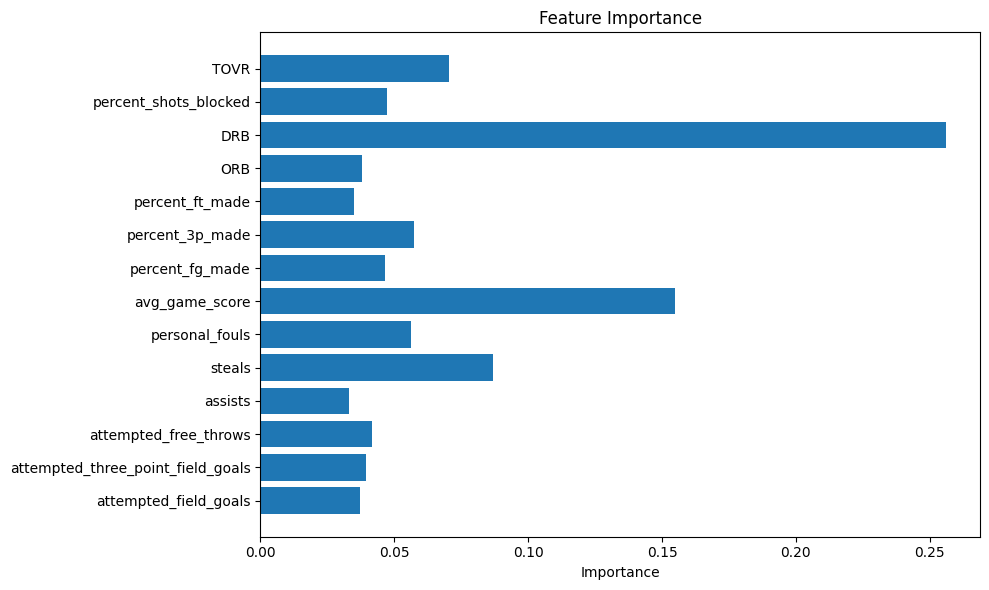

In [ ]:
# First iteration (No hyper-param tuning)

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Preview data
import pandas as pd
df = pd.read_csv('cleaned_data.CSV')
df.head()

feature_cols = [
    'attempted_field_goals',
    'attempted_three_point_field_goals',
    'attempted_free_throws',
    'assists',
    'steals',
    'personal_fouls',
    'avg_game_score',
    'percent_fg_made',
    'percent_3p_made',
    'percent_ft_made',
    'ORB',
    'DRB',
    'percent_shots_blocked',
    'TOVR'
]
# Inputs
X = df[feature_cols]
# Outputs
y = df['team_win']

# Train-test split; random_state ensure reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost with limited estimators for speed
model = XGBClassifier(n_estimators=100, eval_metric='logloss')
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance based on gain
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_cols, importances)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters:
 {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}
Accuracy: 0.8239239798770263
Confusion Matrix:
 [[791 166]
 [149 683]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83       957
           1       0.80      0.82      0.81       832

    accuracy                           0.82      1789
   macro avg       0.82      0.82      0.82      1789
weighted avg       0.82      0.82      0.82      1789



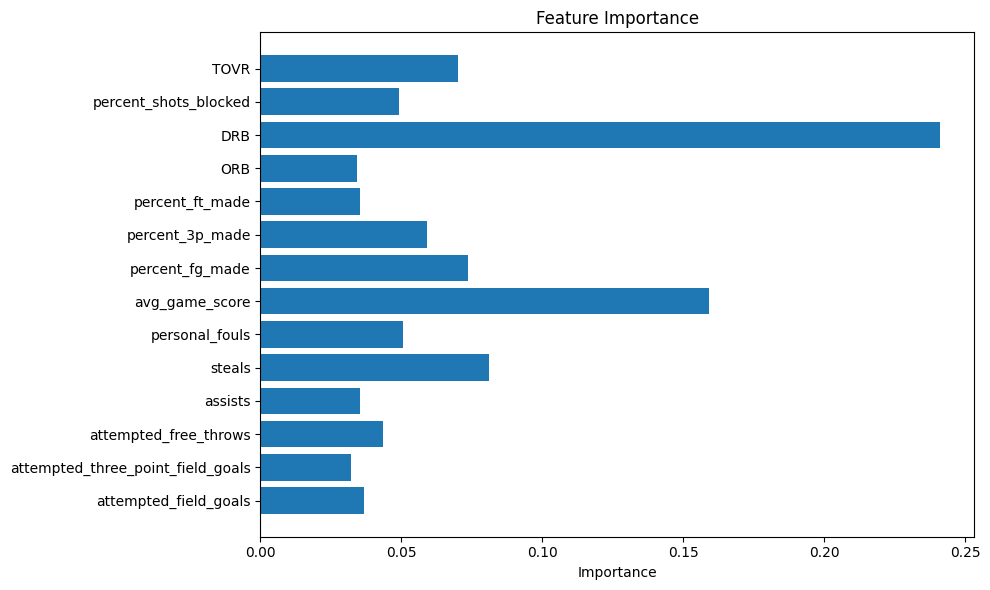

In [ ]:
# Hyperparameter tuning with RandomSearchCV

from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': [100, 500, 1000, 1500, 2000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 4, 6, 8, 12, 16],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1.0],
    'reg_alpha': [0, 0.5, 1, 2],
    'reg_lambda': [0.1, 0.5, 1, 3]
}

model = XGBClassifier(eval_metric='logloss')

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter combos to try
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:\n", random_search.best_params_)
best_model = random_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot feature importances
importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_cols, importances)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()



In [ ]:
# Hyperparameter tuning with Optuna

!pip install optuna
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('cleaned_data.CSV')
feature_cols = [
    'attempted_field_goals',
    'attempted_three_point_field_goals',
    'attempted_free_throws',
    'assists',
    'steals',
    'personal_fouls',
    'avg_game_score',
    'percent_fg_made',
    'percent_3p_made',
    'percent_ft_made',
    'ORB',
    'DRB',
    'percent_shots_blocked',
    'TOVR'
]
X = df[feature_cols]
y = df['team_win']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 2.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 3.0, log=True),
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# Create and run study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Best results
print("Best Hyperparameters:\n", study.best_params)

# Train final model with best params
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance
importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_cols, importances)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 7.6 MB/s eta 0:00:00


FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_data.CSV'

In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()